In [14]:
import numpy as np
import scipy.sparse
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [15]:
l, w = 3, 5                  # meters
heater_temperature = 10      # kelvin, celsius, etc.
T = 5                        # seconds

dx = 10 ** -2
wall_pts = 10

In [16]:
n_pts = (int(l / dx), int(w / dx))
print("Using resolution:", n_pts)

Using resolution: (300, 500)


In [17]:
outer_walls = np.ones(n_pts, dtype=np.bool)
outer_walls[wall_pts:-wall_pts, wall_pts:-wall_pts] = False

idx = int(n_pts[0] / 1.5)
outer_walls[idx: idx + wall_pts, :n_pts[1] // 3] = True
idx = int(n_pts[0] / 2)
outer_walls[idx: idx + wall_pts, :n_pts[1] // 3] = True

interior_pts = np.logical_not(outer_walls)

idx = int(n_pts[1] / 2)
outer_walls[:n_pts[1] // 3, idx: idx + wall_pts] = True
idx = int(n_pts[1] / 1.5)
outer_walls[n_pts[1] // 3:, idx: idx + wall_pts] = True

north_pts = np.logical_or(outer_walls, np.roll(outer_walls, 1, axis=0))
north_pts = np.logical_xor(outer_walls, north_pts)

south_pts = np.logical_or(outer_walls, np.roll(outer_walls, -1, axis=0))
south_pts = np.logical_xor(outer_walls, south_pts)

west_pts = np.logical_or(outer_walls, np.roll(outer_walls, 1, axis=1))
west_pts = np.logical_xor(outer_walls, west_pts)

east_pts = np.logical_or(outer_walls, np.roll(outer_walls, -1, axis=1))
east_pts = np.logical_xor(outer_walls, east_pts)

windows = np.zeros(n_pts, dtype=np.bool)
windows[wall_pts * 2:wall_pts * 10, :wall_pts] = True
windows[:wall_pts, wall_pts * 2:wall_pts * 10] = True

outer_walls = np.logical_xor(outer_walls, windows)

heaters = np.zeros(n_pts, dtype=np.bool)
heaters[-wall_pts*12:-wall_pts*2, -wall_pts*4:-wall_pts*2] = True
heaters[-wall_pts * 4:-wall_pts * 2, n_pts[1] // 2:int(n_pts[1] / 1.5) - wall_pts] = True

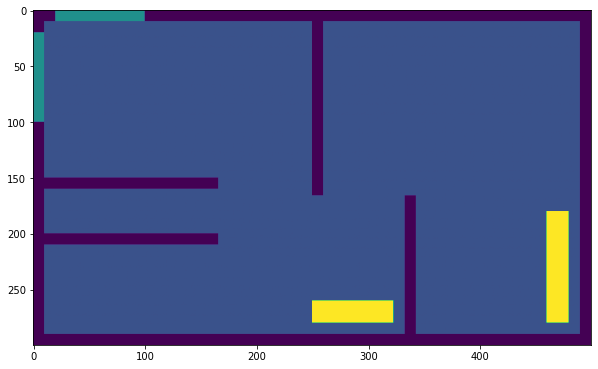

In [18]:
U = np.zeros(n_pts, dtype=np.float64)

U[interior_pts] = 50
U[heaters] = 200
U[outer_walls] = 0
U[windows] = 100

plt.figure(figsize=(10, 10))
plt.imshow(U)
plt.show()

In [19]:
n = n_pts[0] * n_pts[1]
A = scipy.sparse.lil_matrix((n, n), dtype=np.float64)
r = np.zeros(n, dtype=np.float64)
c = lambda i, j: n_pts[0] * j + i
U[:, :] = 0

pbar = tqdm(total=n)
for j in range(n_pts[1]):
    for i in range(n_pts[0]):
        if heaters[i, j]:
            r[c(i, j)] = heater_temperature
        
        if outer_walls[i, j]:
            continue
        elif windows[i, j]:
            A[c(i, j), c(i, j)] = 1 / dx ** 2
        elif north_pts[i, j]:
            A[c(i, j), c(i, j + 1)] = 1 / dx ** 2
            A[c(i, j), c(i, j - 1)] = 1 / dx ** 2
            A[c(i, j), c(i, j)]     = -4 / dx ** 2
            A[c(i, j), c(i + 1, j)] = 2 / dx ** 2
        elif south_pts[i, j]:
            A[c(i, j), c(i, j + 1)] = 1 / dx ** 2
            A[c(i, j), c(i, j - 1)] = 1 / dx ** 2
            A[c(i, j), c(i, j)]     = -4 / dx ** 2
            A[c(i, j), c(i - 1, j)] = 2 / dx ** 2
        elif west_pts[i, j]:
            A[c(i, j), c(i, j + 1)] = 2 / dx ** 2
            A[c(i, j), c(i + 1, j)] = 1 / dx ** 2
            A[c(i, j), c(i, j)]     = -4 / dx ** 2
            A[c(i, j), c(i - 1, j)] = 1 / dx ** 2
        elif east_pts[i, j]:
            A[c(i, j), c(i, j - 1)] = 2 / dx ** 2
            A[c(i, j), c(i + 1, j)] = 1 / dx ** 2
            A[c(i, j), c(i, j)]     = -4 / dx ** 2
            A[c(i, j), c(i - 1, j)] = 1 / dx ** 2
        else:
            A[c(i, j), c(i, j + 1)] = 1 / dx ** 2
            A[c(i, j), c(i, j - 1)] = 1 / dx ** 2
            A[c(i, j), c(i, j)]     = -4 / dx ** 2
            A[c(i, j), c(i + 1, j)] = 1 / dx ** 2
            A[c(i, j), c(i - 1, j)] = 1 / dx ** 2

        pbar.update(1)

pbar.close()
A = A.tocsr()

nonzero_idxs = []
zero_idxs = []

for j in range(n_pts[1]):
    for i in range(n_pts[0]):
        if outer_walls[i, j]:
            zero_idxs.append(c(i, j))
        else:
            nonzero_idxs.append(c(i, j))

nonzero_idxs = np.array(nonzero_idxs)
zero_idxs = np.array(zero_idxs)

A = A[nonzero_idxs].tocsc()[:, nonzero_idxs].tocsr()
r = r[nonzero_idxs]

 87%|████████▋ | 130080/150000 [00:02<00:00, 64742.73it/s]


In [49]:
U = U.reshape(n, order='F')[nonzero_idxs]

dt = 0.25 * dx ** 2
n_iterations = int(np.ceil(T / dt))

for _ in tqdm(range(n_iterations)):
    U = U + dt * (A.dot(U) + r)

  4%|▍         | 7773/200000 [00:08<03:21, 953.52it/s]


KeyboardInterrupt: 

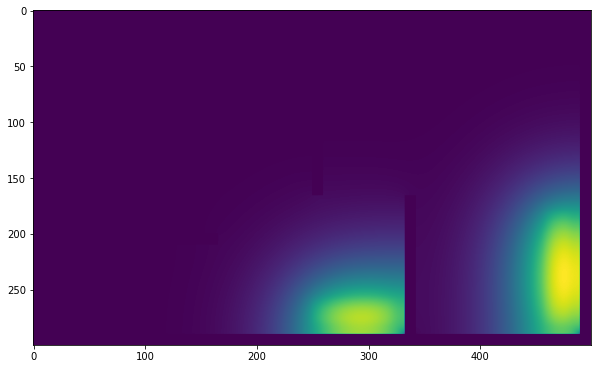

In [50]:
U_temp = np.zeros(n, dtype=np.float64)
U_temp[nonzero_idxs] = U
U = U_temp
U = U.reshape(n_pts, order='F')

plt.figure(figsize=(10, 10))
plt.imshow(U)
plt.show()

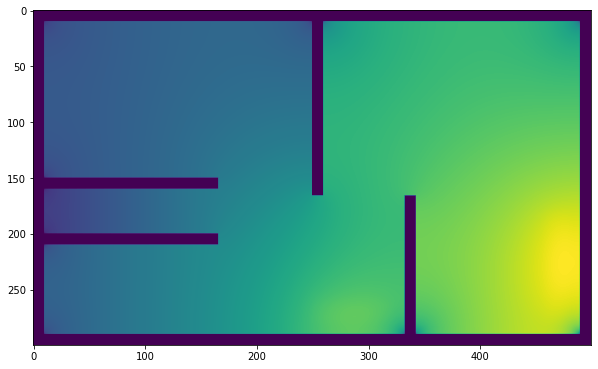

In [20]:
U_SS_short = linalg.spsolve(-A, r)
U_SS = np.zeros(n, dtype=np.float64)
U_SS[nonzero_idxs] = U_SS_short
U_SS[zero_idxs] = 0
U_SS = U_SS.reshape(n_pts, order='F')

plt.figure(figsize=(10, 10))
plt.imshow(U_SS)
plt.show()